In [ ]:
# Cloning the project repository
# !git clone https://github.com/Felipe-Cancio/Dinamic-Draft-Reading.git

In [ ]:
# ANOTAÇÕES
# Formas de pegar os pontos das bounding boxes do tensor
# results[0].boxes.xyxy[0,0].int().item()  - Pytorch function sem arredondar
# results[0].boxes.xyxy[0,0].round().int().item() - Pytorch function arredondando
# round(results[0].boxes.xyxy[0,0].item()) - Python round function arredondando
# a = list(zip(os.listdir('runs/detect/predict2/crops/DM'),recognMarks2()))
# next(os.walk('runsos.listdir('runs/detect/predict/crops/DM')
# print(y1-10, y2+10, x1-10, x2+10)
# print(img[(y1-10:y2+10,x1-10:x2+10).clip(min=0)])
# print('-'*20)
# Tenho que fazer uma funcao p melhorar o tamanho da boundig box sem invadir outras bounding boxes
# displayImg(boxes_imgs[0])
# reader.recognize(boxes_imgs[0], allowlist="123456789M", detail=0)[0]
# draft_mark_values
# print(results_boxes[:,-2:])
# results_boxes[:,-2:].sort(dim=0, descending=True).indices
# results_boxes[:,-2:][0].sum()
# results_boxes[:,-2:].sum(1)
# print(draft_mark_values)
# print(sorted_boxes)
# list(filter(lambda m: draft_mark_values.index(m) if m[-1] == 'M' else 0, draft_mark_values))

In [ ]:
# Libs
from ultralytics import YOLO
from matplotlib import pyplot as plt
import easyocr
import cv2 as cv
import os

In [ ]:
# VISUALIZAR IMAGEM
def displayImg(img, title='', cmap=None):
  plt.figure(figsize=(25,25))
  plt.subplot(122),plt.imshow(img, cmap=cmap)
  plt.title(title), plt.xticks([]), plt.yticks([])
  plt.show()

# VISUALIZAR A COMPARAÇÃO DE DUAS IMAGENS
def compareImgs(image1, image2, title1, title2, cmap=None):
  plt.figure(figsize=(22,22))
  plt.subplot(121),plt.imshow(image1, cmap=cmap)
  plt.title(title2), plt.xticks([]), plt.yticks([])
  plt.figure(figsize=(22,22))
  plt.subplot(122),plt.imshow(image2, cmap=cmap)
  plt.title(title2), plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
# Função p/ ordernar as boundig boxes detectadas (baixo p/ cima, direita p/ esquerda)
def sortBoxes(boxes_xyxy): 
  boxes_sorted = boxes_xyxy.clone()                                        # Clonando o tensor com as coordenadas das boundig boxes
  # Achando os indices das boxes ordenadas canto inferior direito
  indices_sorted = boxes_xyxy[:,-2:].sum(1).sort(dim=0, descending=True).indices 
  boxes_sorted = boxes_xyxy[indices_sorted]                                # Ordenando novo tensor pelos indices
  return boxes_sorted                                                      # Retornando tensor das bouding boxes ordenadas

# Função p/ extratir marcas de calado da imagem
def extractBoxes(img, boxes_xyxy, expand):
  draftMarksImgs = list()                                     # Lista que irá conter as imagens das marcas de calado cortadas
  for box in boxes_xyxy:                                       # Iterando a lista de bounding boxes
    # x1, y1, x2, y2 = [point.int().item() for point in box]    # Extraindo os pontos de cada bounding box (antigo)
    idxs = [point.item() for point in box]    # Extraindo os pontos de cada bounding box
    x1, y1, x2, y2 = idxs
    x1, y1 = [0 if idx-expand <= 0 else idx-expand for idx in idxs[:2]]
    draftMarksImgs.append(img[y1:y2+expand,x1:x2+expand]) # img[y1-10:y2+10,x1-10:x2+10] Cortando as bounding boxes da imagem
  return draftMarksImgs                                        # Retornando as imagens cortadas das marcas de calado detectadas

# Função p/ classificar o valor das marcas de calado 
def recognMarks(boxes_imgs):
  draft_mark_values = list()                               # Lista que irá conter os valores das marcas de calado detectadas
  for boxe_img in boxes_imgs:                              # Iterando a lista das imagens das marcas de calado
    draft_mark_value = reader.recognize(boxe_img, allowlist="123456789M", detail=0)[0]    # Reconhecendo valor da marca de calado
    draft_mark_values.append(draft_mark_value)                                   # Salvando valor da marca de calado
  return draft_mark_values                                     # Retornando lista com os valores das marcas de calado

# Função p/ classificar o valor das marcas de calado das imagens extraidas 
def recognMarks2():
  dmValues = list()                                              # Lista que irá conter os valores das marcas de calado detectadas
  draftMarksImgs = os.listdir('runs/detect/predict/crops/DM')   # Caminhos das imagens das marcas de calado cortadas YOLO
  for draftMarkImg in draftMarksImgs:                            # Iterando a lista das imagens das marcas de calado
    # Reconhecendo valor da marca de calado
    dmValue = reader.recognize('runs/detect/predict/crops/DM/' + draftMarkImg, allowlist="123456789M", detail=0)[0]
    dmValues.append(dmValue)                                     # Salvando valor da marca de calado
  return dmValues                                                # Retornando lista com os valores das marcas de calado

# Função p/ inferir o calado com base no valor e coord das marcas de calado
def predictDraft(draft_mark_values, boxes_xyxy):
  draft = ''
  draft += draft_mark_values[0] + '.'
  m_idx = get_idx(draft_mark_values, 'M')[0] + 1
  y2 = boxes_xyxy[m_idx,3]
  for i, val in enumerate(draft_mark_values[m_idx:]):
    draft += val if boxes_xyxy[m_idx+i,3] > y2 - 10 else ''
  
  return round(float(draft[::-1]) - 1, 2)
  
def drawDigits(img, boxes_xyxy, draft_mark_values):
  test_img = img.copy()
  for i, box in enumerate(boxes_xyxy):
    x1, y1, x2, y2 = [point.int().item() for point in box]
    cv.putText(test_img, str(draft_mark_values[i]), (x2 + 50, y2), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA) # (DEBUG)
  displayImg(test_img)                                          # Visualizando a imagem com os valores (DEBUG)

def get_idx(lst, value) -> list:
    indices = list()
    i = 0
    while True:
        try:
            i = lst.index(value, i)         # find an occurrence of value and update i to that index
            indices.append(i)            # add i to the list
            i += 1                       # advance i by 1
        except ValueError as e:
            break
    return indices

In [ ]:
model = YOLO('Draft_Marks_Detect_YOLO_v3.pt')  # Carregando o modelo de detecção na memória
reader = easyocr.Reader(['en'], gpu=False)     # Carregando o modelo de OCR na memória

In [65]:
img = cv.imread("1.jpg")
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [66]:
results = model.predict(img, conf=0.5, save=False, save_crop=False,)   # Detectando as marcas de calado na imagem
results_boxes = results[0].boxes.xyxy.int()
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


0: 640x640 11 DMs, 186.8ms
Speed: 3.0ms preprocess, 186.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


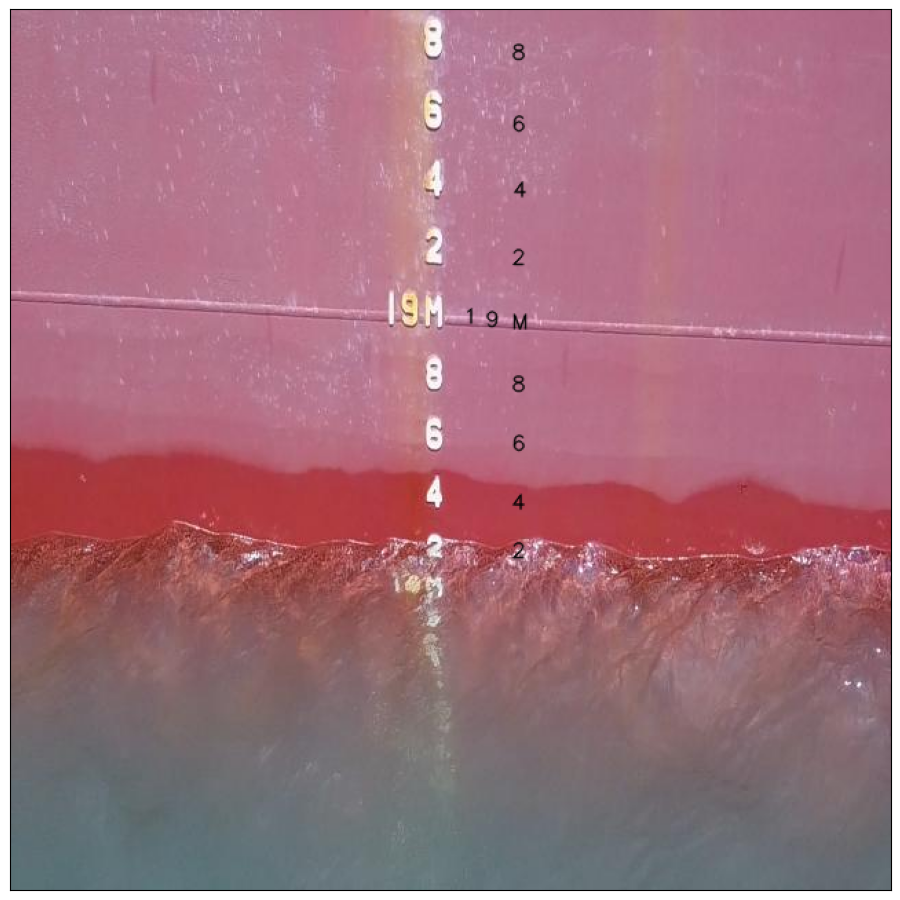

18.2

In [69]:
sorted_boxes = sortBoxes(results_boxes)
boxes_imgs = extractBoxes(img, sorted_boxes, 4)
# displayImg(boxes_imgs[-1])
# reader.recognize(boxes_imgs[-1], allowlist="123456789M", detail=0)[0]
draft_mark_values = recognMarks(boxes_imgs)
drawDigits(img, sorted_boxes, draft_mark_values)
predictDraft(draft_mark_values, sorted_boxes)